In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

import shap

In [2]:

df = pd.read_csv("churn.csv")

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
print(df.shape)

(7043, 21)


In [5]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [6]:
print(df.isnull().sum())

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [7]:
# Converting TotalCharges to numeric, coerce errors into NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop rows where TotalCharges could not be converted
df = df.dropna(subset=['TotalCharges'])


In [8]:
if 'customerID' in df.columns:
    df.drop(columns=['customerID'], inplace=True)

In [9]:
# Churn rate
churn_rate = df['Churn'].value_counts(normalize=True)['Yes'] * 100
print(f"Churn Rate: {churn_rate:.2f}%")


Churn Rate: 26.58%


In [10]:
fig = px.pie(df, names='Churn', title='Customer Churn Rate', hole=0.4)
fig.show()

In [11]:
fig_contract = px.histogram(df, x='Contract', color='Churn', barmode='group',
                            title="Churn by Contract Type")
fig_contract.show()

In [12]:
Monthly_charges = px.histogram(df, x='MonthlyCharges', color='Churn', nbins=40,
                           title="Monthly Charges Distribution by Churn Status")
Monthly_charges.show()

In [13]:
# Monthly Charges vs. Tenure with churn coloring
fig3 = px.scatter(df, x='tenure', y='MonthlyCharges', color='Churn', title='Monthly Charges vs Tenure')
fig3.show()

In [14]:
# Encode target separately
df['Churn_Label'] = LabelEncoder().fit_transform(df['Churn'])


# Identify categorical and numeric columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()


# Remove target from categorical list
if 'Churn' in categorical_cols:
    categorical_cols.remove('Churn')


# One-hot encode only categorical features
df_encoded = pd.get_dummies(df[categorical_cols], drop_first=True)


# Combine numeric + encoded categorical
X = pd.concat([df[numeric_cols], df_encoded], axis=1).drop(columns=['Churn_Label'], errors='ignore')
y = df['Churn_Label']

In [15]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn', 'Churn_Label'],
      dtype='object')

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [17]:
# Training
rf = RandomForestClassifier(n_estimators=200, random_state=42)
log_reg = LogisticRegression(max_iter=500, random_state=42)
xgb = XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, random_state=42)

In [18]:
# Ensemble Stacking

stacking_model = StackingClassifier(
estimators=[
('rf', rf),
('log_reg', log_reg),
('xgb', xgb)
],
final_estimator=LogisticRegression(),
cv=5
)


stacking_model.fit(X_train, y_train)
y_pred = stacking_model.predict(X_test)


print("\n Ensemble Stacking Classifier Results")
print(classification_report(y_test, y_pred))

c:\Users\manoj\anaconda3\envs\Projects\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

c:\Users\manoj\anaconda3\envs\Projects\Lib\site-packages\xgboost\training.py:183: UserWarning:

[13:02:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\manoj\anaconda3\envs\Projects\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
  


 Ensemble Stacking Classifier Results
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1033
           1       0.65      0.54      0.59       374

    accuracy                           0.80      1407
   macro avg       0.75      0.72      0.73      1407
weighted avg       0.79      0.80      0.79      1407



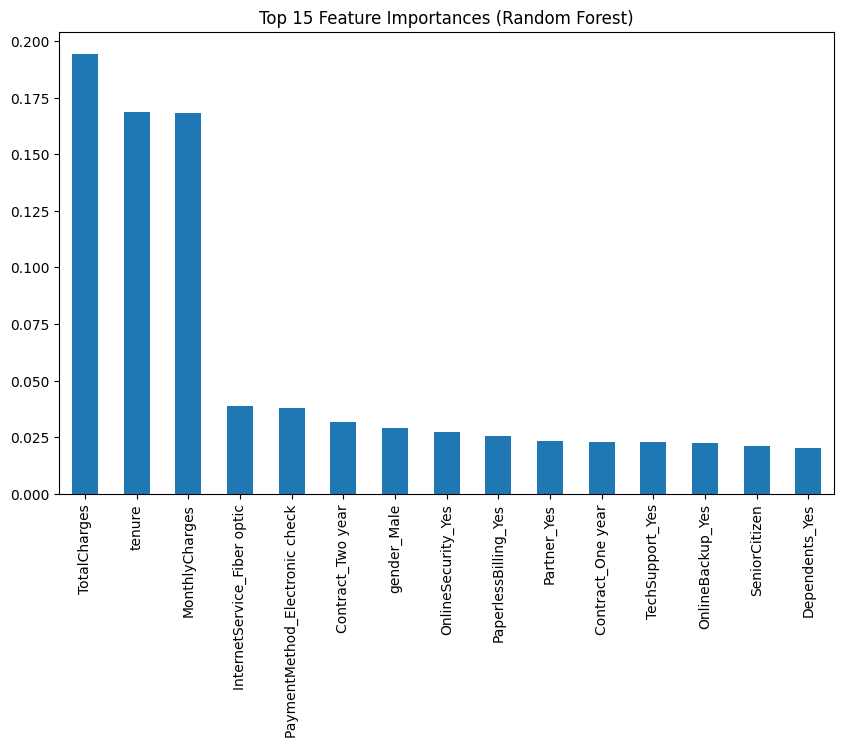

In [19]:
rf.fit(X_train, y_train)
importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)[:15]


plt.figure(figsize=(10,6))
importances.plot(kind='bar')
plt.title("Top 15 Feature Importances (Random Forest)")
plt.show()


Model Performance
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.51      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407


 Top 10 Feature Importances
TotalCharges                      0.194313
tenure                            0.168529
MonthlyCharges                    0.167972
InternetService_Fiber optic       0.038913
PaymentMethod_Electronic check    0.037898
Contract_Two year                 0.031862
gender_Male                       0.028939
OnlineSecurity_Yes                0.027288
PaperlessBilling_Yes              0.025595
Partner_Yes                       0.023280
dtype: float64


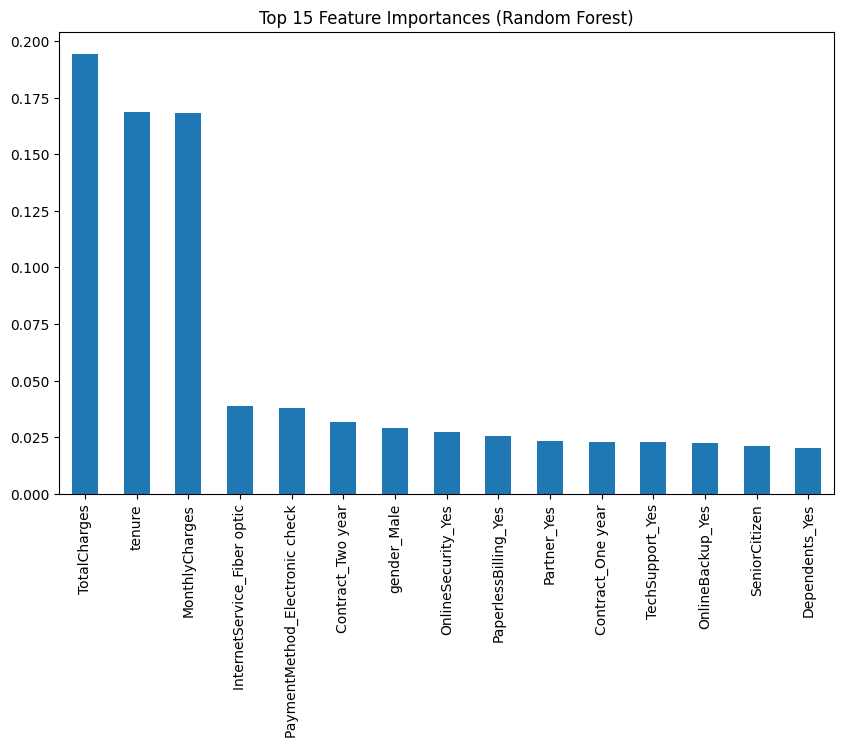

In [20]:
from sklearn.metrics import classification_report, confusion_matrix

print("Model Performance")
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

print("\n Top 10 Feature Importances")
print(importances.head(10))


plt.figure(figsize=(10,6))
importances.plot(kind='bar')
plt.title("Top 15 Feature Importances (Random Forest)")
plt.show()

In [21]:
print("Non-numeric columns in X_train:")
print(X_train.select_dtypes(include=['object']).head())

print("Non-numeric columns in X_test:")
print(X_test.select_dtypes(include=['object']).head())


Non-numeric columns in X_train:
Empty DataFrame
Columns: []
Index: [1413, 7003, 3355, 4494, 3541]
Non-numeric columns in X_test:
Empty DataFrame
Columns: []
Index: [974, 619, 4289, 3721, 4533]


In [22]:
# Force every column to numeric, coerce bad values to NaN
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test  = X_test.apply(pd.to_numeric, errors='coerce')

# Handle NaNs if coercion created them
X_train = X_train.fillna(0)
X_test  = X_test.fillna(0)


In [23]:
# Convert bools to ints
X_train = X_train.astype({col: 'int64' for col in X_train.select_dtypes('bool').columns})
X_test  = X_test.astype({col: 'int64' for col in X_test.select_dtypes('bool').columns})

print(X_train.dtypes.unique())


[dtype('int64') dtype('float64')]


In [24]:
print(X_train.dtypes.unique())

[dtype('int64') dtype('float64')]


In [25]:
# Ensure no bools or objects remain
X_train = X_train.apply(pd.to_numeric, errors='coerce').fillna(0)
X_test  = X_test.apply(pd.to_numeric, errors='coerce').fillna(0)

# Convert any bools to int
X_train = X_train.astype({col: 'int64' for col in X_train.select_dtypes('bool').columns})
X_test  = X_test.astype({col: 'int64' for col in X_test.select_dtypes('bool').columns})



Shap

100%|===================| 2813/2814 [06:25<00:00]        

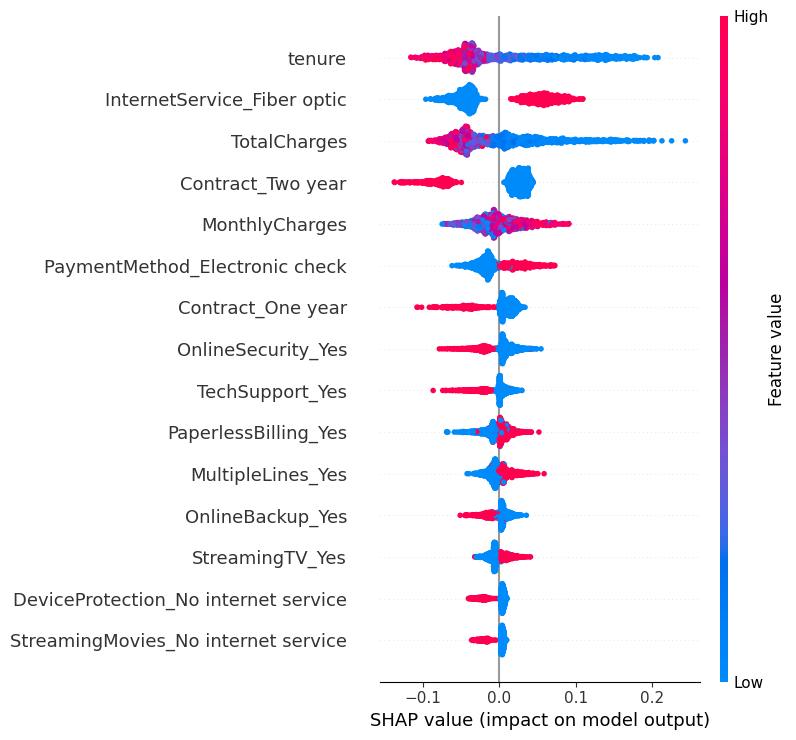

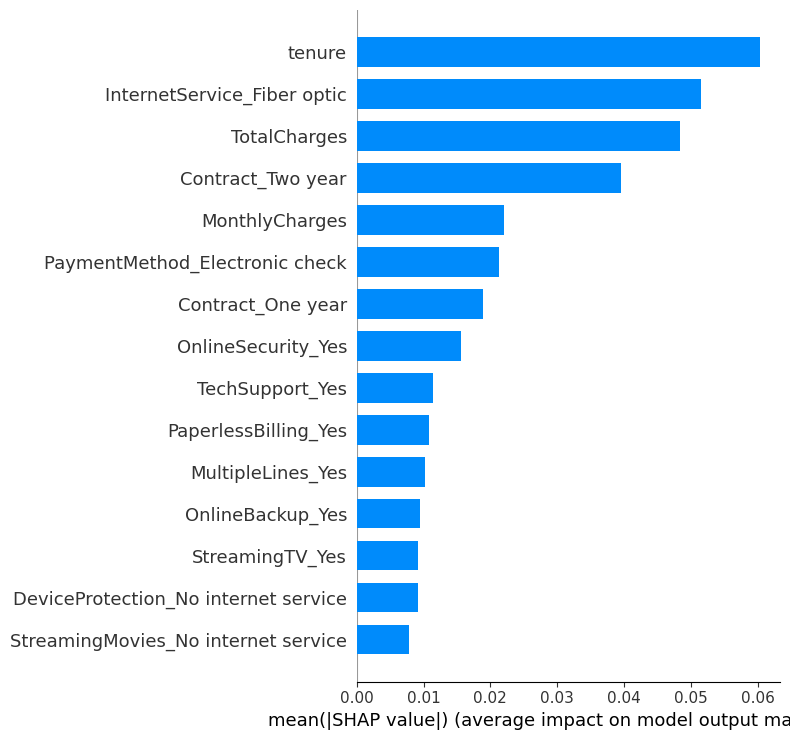

In [26]:
model = rf  


explainer = shap.TreeExplainer(model, X_train, feature_perturbation="interventional")
shap_values = explainer(X_test, check_additivity=False)


explainer = shap.TreeExplainer(rf, X_train)
shap_values = explainer(X_test, check_additivity=False)

if len(shap_values.values.shape) == 3:
    shap_class1 = shap_values.values[:, :, 1]  # take churn=Yes
else:
    shap_class1 = shap_values.values

shap.summary_plot(shap_class1, X_test, plot_type="dot", max_display=15)
shap.summary_plot(shap_class1, X_test, plot_type="bar", max_display=15)